In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mne import time_frequency, create_info, EpochsArray

In [2]:
channels_path = r'data\channel_names_t150327002.npy'
lfps_path = r'data\LFP_t150327002_GoAlignment.npy'

In [23]:
channels = np.load(channels_path)
lfp = np.load(lfps_path) # shape = trials x ch x time

In [24]:
print("Number of channels: %d"%(channels.shape[0]))
print("Trials: %d, channels: %d, timestamps: %d"%(lfp.shape[0],lfp.shape[1],lfp.shape[2]))

Number of channels: 48
Trials: 106, channels: 48, timestamps: 200


In [25]:
ch_name = 'PMd'
# Select the channels that contain ch_name in their name
channel_mask_PMd = np.array([False if channel.find(ch_name) == -1 else True for channel in channels])

In [26]:
print("Number of %s channels: %d"%(ch_name,channels[channel_mask_PMd].shape[0]))

Number of PMd channels: 24


In [27]:
# ignore if you don't want to zero pad
# zero padding each trial
n_zeros = 200
lfps_pad = np.pad(lfp, ((0, 0),(0, 0),(n_zeros, n_zeros)), 'constant', constant_values=(0, 0))
lfps=lfps_pad
print("Shape lfps: (%s,%s,%s)"%lfps.shape)

Shape lfps: (106,48,600)


In [28]:
# Compute the psd using welch
s_freq = 1000 # Hz
w_size = 150
psd_welch_1, freqs_welch_1 = time_frequency.psd_array_welch(lfps,fmax=80,sfreq=s_freq,n_per_seg=w_size)
print("Spectrum shape: (%s,%s,%s)"%psd_welch_1.shape)
print("Number of freqs: %d"%freqs_welch_1.shape[0])

Effective window size : 0.256 (s)
Spectrum shape: (106,48,21)
Number of freqs: 21


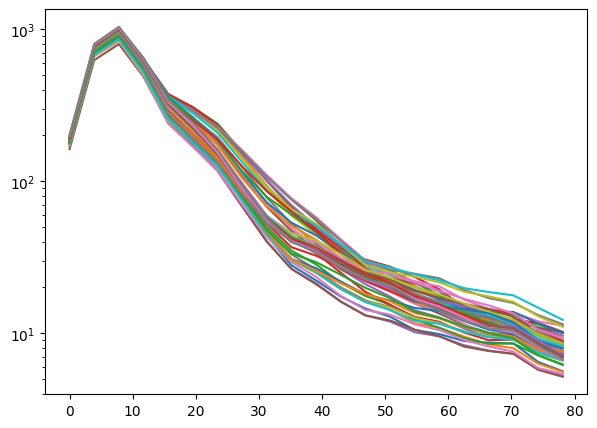

In [29]:
# print the mean power spectrum for each channel (mean across trials)
_,ax = plt.subplots(figsize=(7,5))
for i in range(psd_welch_1.mean(axis=(0)).shape[0]):
    plt.semilogy(freqs_welch_1,psd_welch_1.mean(axis=(0))[i])
plt.show()

In [30]:
plt.close('all')

In [31]:
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

In [32]:
# Initialize FOOOF object
fm = FOOOF()
# Define frequency range across which to model the spectrum
freq_range = [0, 80]


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 79 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                         

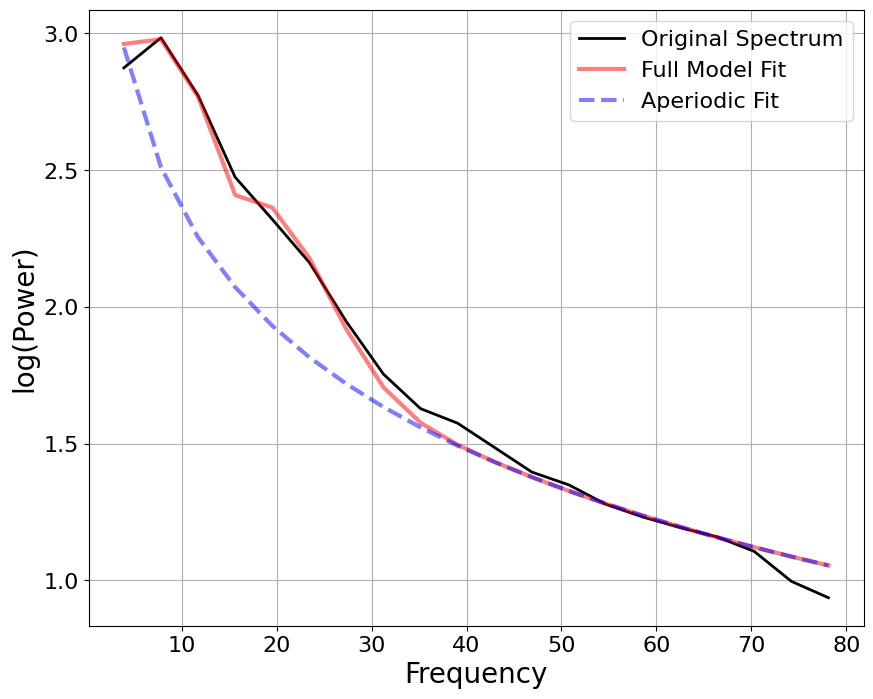

In [33]:
# Report: fit the model, print the resulting parameters, and plot the reconstruction
channel=35
fm.report(freqs_welch_1, psd_welch_1.mean(axis=(0))[channel])



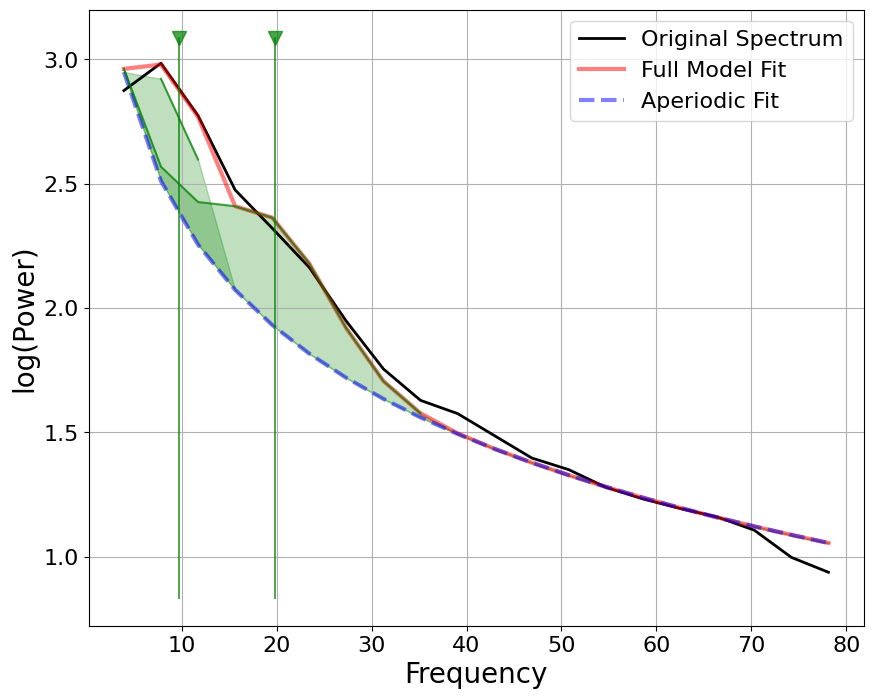

In [34]:
# Combine peak representations
fm.plot(plot_aperiodic=True, plot_peaks='line-shade-outline', plt_log=False)

In [40]:
# fit fooof for all channels and trials
def get_foof_param(channels_idx,psd_welch_1,freqs_welch_1):
    ch_param = []

    for ch in channels_idx:
        for trial in range(psd_welch_1.shape[0]):
            p=fm.fit(freqs_welch_1, psd_welch_1[trial,ch])
            ch_param.append(fm.peak_params_[:,0])
    return ch_param

In [41]:
channels_idx=np.where(channel_mask_PMd == True)[0]
param_PMd = get_foof_param(channels_idx,psd_welch_1,freqs_welch_1)


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 3.91 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= 

In [42]:
import seaborn as sns

<AxesSubplot: ylabel='Density'>

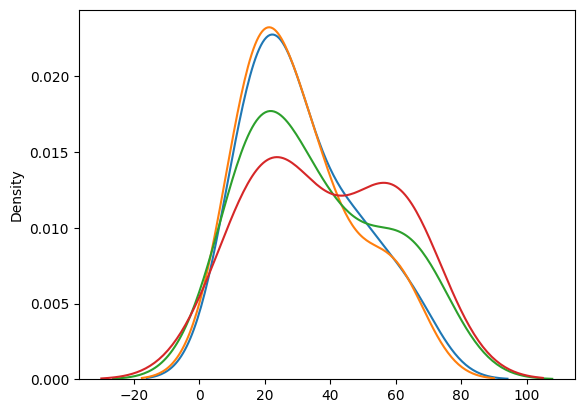

In [54]:
all_param_list = np.concatenate(param_PMd[:6])
sns.kdeplot(all_param_list)
all_param_list = np.concatenate(param_PMd[6:11])
sns.kdeplot(all_param_list)
all_param_list = np.concatenate(param_PMd[11:16])
sns.kdeplot(all_param_list)
all_param_list = np.concatenate(param_PMd[16:20])
sns.kdeplot(all_param_list)

In [49]:
param_PMd[:6]

[array([15.15387335, 29.41545774, 48.8012753 , 65.41264701]),
 array([13.07622955, 28.22426745]),
 array([26.42038127, 45.74727707]),
 array([18.84195186, 47.84057496]),
 array([12.67369865, 23.21096589, 62.28961082]),
 array([13.77113052, 21.14721419, 28.78897451, 36.91848312])]

c:\Users\camil\.virtualenvs\Brainhack-Marseille-2022-ym7AmNbj\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:orange'` for same effect.
  warnings.warn(msg, FutureWarning)


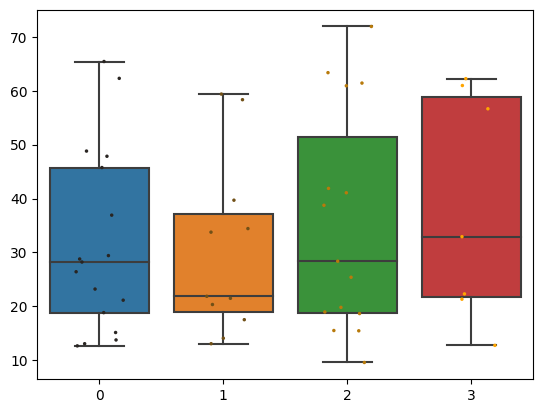

In [53]:
sns.boxplot(data=[np.concatenate(param_PMd[:6]),np.concatenate(param_PMd[6:11]),np.concatenate(param_PMd[11:16]),np.concatenate(param_PMd[16:20])])
ax = sns.stripplot(data=[np.concatenate(param_PMd[:6]),np.concatenate(param_PMd[6:11]),np.concatenate(param_PMd[11:16]),np.concatenate(param_PMd[16:20])], color="orange", jitter=0.2, size=2.5)

plt.show()

## Not used --------------

In [ ]:
info = create_info(ch_names=channels.tolist(), sfreq=1000,ch_types='seeg')
n_times = lfps.shape[2]  # Just over 1 second epochs
n_epochs = lfps.shape[0]
# Add a 50 Hz sinusoidal burst to the noise and ramp it.
t = np.arange(n_times)

events = np.empty((n_epochs, 3), dtype=int)
first_event_sample = 0
event_id = dict(sin50hz=1)
for k in range(n_epochs):
    events[k, :] = first_event_sample + k * n_times, 0, 1

epochs = EpochsArray(data=lfps, info=info, events=events, event_id=event_id)

epochs.average().plot()

psd_multitaper_2, freqs_multitaper_2 = epochs.compute_psd(method='multitaper',fmax=80, output='power').get_data(return_freqs=True)

In [ ]:
psd_multitaper_2,freqs_multitaper_2= epochs.compute_psd(method="multitaper",fmax=80).get_data(return_freqs=True)

In [ ]:
epochs.plot_psd(fmax=80,method='multitaper',average=True,dB=False)

In [ ]:
psd_multitaper_2.plot_psd(average=True)

In [ ]:
psd_multitaper.get_data()[:,0].shape

In [ ]:
psd_multitaper_1[0,0]

In [ ]:
psd_multitaper_2.get_data().mean(axis=0)[0]-psd_multitaper_2.get_data().mean(axis=0)[0]